In [32]:
path = r'C:/Users/ruw/Desktop'
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, rf'{path}\RA\penicilin\Libaries')

In [33]:
from lca import LCA


In [34]:
trial_path = r"C:\Users\ruw\Desktop\RA\penicilin\data\database.xlsx"
matching_database = "ev391cutoff"
lca_var = LCA(path, matching_database, matching_database)
impact_cat = lca_var.lcia_impact_method()
impact_cat_GWP = impact_cat[1]
impact_cat_GWP

('ReCiPe 2016 v1.03, midpoint (H) - no biogenic',
 'climate change',
 'global warming potential (GWP1000)')

In [35]:
# Importing libraries
import bw2io as bi
import bw2data as bd
import bw2calc as bc
import pandas as pd

import standards as s


In [36]:
def import_excel_database_to_brightway(data, matching_database, path_github):
    # Save the data to a temporary file that can be used by ExcelImporter
    temp_path = s.join_path(path_github, r"data\temp.xlsx")

    data.to_excel(temp_path, index=False)
    
    # Use the temporary file with ExcelImporter
    imp = bi.ExcelImporter(temp_path)  # the path to your inventory excel file
    imp.apply_strategies()

    # Loop through each database and match
    print(f"Matching database: {matching_database}")
    imp.match_database(matching_database, fields=('name', 'unit', 'location', 'reference product'))
    if list(imp.unlinked):
        print(f"Unlinked items after matching {matching_database}: {list(imp.unlinked)}")

    # Match without specifying a database
    # imp.match_database(fields=('name', 'unit', 'location'))

    # Generate statistics and write results
    imp.statistics()
    imp.write_excel(only_unlinked=True)
    unlinked_items = list(imp.unlinked)
    imp.write_database()

    # Print unlinked items if needed
    if unlinked_items:
        print(unlinked_items)

    import_excel_database_to_brightway.has_been_called = True

import_excel_database_to_brightway.has_been_called = False

def reload_database(matching_database, system_path, path_github, proj_database, sheet):
    reload_database.has_been_called = True
    user_input = input(f"Do you want to reload the {proj_database}? Enter 'y' for yes and 'n' for no")
    
    if user_input.lower() == 'y':

        data = pd.read_excel(system_path, sheet_name=sheet)

        # Removing the old database
        db_old = bd.Database(proj_database)
        db_old.deregister()

        import_excel_database_to_brightway(data, matching_database, path_github)

    elif user_input.lower() == 'n':
        print('You selected to not reload')

    else:
        print('Invalid argument, try again')
        reload_database(matching_database, matching_database, system_path)

reload_database.has_been_called = False

def extract_excel_sheets(system_path, matching_database):
    # Use a context manager to open the Excel file
    with pd.ExcelFile(system_path) as excel_file:
        # Get the sheet names
        sheet_names = excel_file.sheet_names
    
    sheets_to_import = []
    for sheet in sheet_names:
        if matching_database in sheet:
            sheets_to_import.append(sheet)

    return sheets_to_import

def extract_database(data, system_path, path_github, matching_database, sheet="ev391cutoff"):
    proj_database_str = data.columns[1]
    if proj_database_str not in bd.databases:
        import_excel_database_to_brightway(data, matching_database, path_github)

    # Reload databases if needed
    if import_excel_database_to_brightway.has_been_called is False:
        reload_database(matching_database, system_path, path_github, proj_database_str, sheet)

def import_databases(matching_database, path, sensitivty=False):

    path_github, ecoinevnt_paths, system_path = s.data_paths(path)

    # Check if Ecoinvent databases are already present
    if matching_database in bd.databases:# and 'ev391apos' in bd.databases and 'ev391cutoff' in bd.databases:
        pass
        # print('Ecoinvent 3.9.1 is already present in the project.')
    else:

        # Import Consequential database
        ei = bi.SingleOutputEcospold2Importer(dirpath=ecoinevnt_paths[matching_database], db_name=matching_database)
        ei.apply_strategies()
        ei.statistics()
        ei.write_database()

    sheets_to_import = extract_excel_sheets(system_path, matching_database)
    if sensitivty is False:
        sheets_to_import = sheets_to_import[0]

    data = pd.read_excel(system_path, sheet_name=sheets_to_import)

    if isinstance(data, pd.DataFrame):
        extract_database(data, system_path, path_github, matching_database)
    elif isinstance(data, dict):
        for sheet, db in data.items():
            extract_database(db, system_path, path_github, matching_database, sheet=sheet)
            import_excel_database_to_brightway.has_been_called = False
    else:
        print("Wrong data format")
    


In [37]:
path_github, ecoinevnt_paths, system_path = s.data_paths(path)

In [38]:
# Use a context manager to open the Excel file
with pd.ExcelFile(trial_path) as excel_file:
    # Get the sheet names
    sheet_names = excel_file.sheet_names

# Print the sheet names
print(sheet_names)


['ev391cutoff', 'ev391cutoff CN', 'ev391cutoff IT', 'ev391cutoff CH', 'ev391cutoff US', 'FU scaling']


In [39]:
sheets_to_import = []
for sheet in sheet_names:
    if matching_database in sheet:
        sheets_to_import.append(sheet)

sheets_to_import

['ev391cutoff',
 'ev391cutoff CN',
 'ev391cutoff IT',
 'ev391cutoff CH',
 'ev391cutoff US']

In [40]:
import_databases(matching_database, path, sensitivty=True)

Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 3.13 seconds
Matching database: ev391cutoff
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


23 datasets
208 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_IN-unlinked.xlsx


0% [#######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/09/2025 14:40:51
  Finished: 05/09/2025 14:40:51
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 6.32
Created database: penicillin_cut_off_IN
Extracted 1 worksheets in 0.05 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_lis

Writing activities to SQLite3 database:


23 datasets
208 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_CN-unlinked.xlsx


0% [#######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/09/2025 14:40:57
  Finished: 05/09/2025 14:40:57
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 6.35
Created database: penicillin_cut_off_CN
Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_li

Writing activities to SQLite3 database:


23 datasets
204 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_IT-unlinked.xlsx


0% [#######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/09/2025 14:41:03
  Finished: 05/09/2025 14:41:03
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 6.33
Created database: penicillin_cut_off_IT
Extracted 1 worksheets in 0.03 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_lis

Writing activities to SQLite3 database:


23 datasets
204 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_CH-unlinked.xlsx


0% [#######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/09/2025 14:41:09
  Finished: 05/09/2025 14:41:09
  Total time elapsed: 00:00:00
  CPU %: 208.30
  Memory %: 6.28
Created database: penicillin_cut_off_CH
Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_li

Writing activities to SQLite3 database:


23 datasets
208 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\ruw\AppData\Local\pylca\Brightway3\Penicillin.7179b081106185b3e43fbe3ebfd7f229\output\db-matching-penicillin_cut_off_US-unlinked.xlsx


0% [#######################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/09/2025 14:41:15
  Finished: 05/09/2025 14:41:15
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 6.31
Created database: penicillin_cut_off_US


In [41]:
for sheet in sheets_to_import:
    data = pd.read_excel(system_path, sheet_name=sheet)
    db = data.columns[1]

In [42]:
func_unit = {}
# Check if the database is case1
for sheet in sheets_to_import:
    data = pd.read_excel(system_path, sheet_name=sheet)
    db_name = data.columns[1]
    db = bd.Database(db_name)
    func_unit[db_name] = []
    # print(db)
    for act in db:
        temp = act['name']
        # Check if the flow is valid and add to the flow list
        if "defined" in temp:
            func_unit[db_name].append({act : 1})

func_unit


{'penicillin_cut_off_IN': [{'Penicillin V, defined system' (unit, DK, None): 1},
  {'Penicillin G, defined system' (unit, DK, None): 1}],
 'penicillin_cut_off_CN': [{'Penicillin V, defined system' (unit, DK, None): 1},
  {'Penicillin G, defined system' (unit, DK, None): 1}],
 'penicillin_cut_off_IT': [{'Penicillin V, defined system' (unit, DK, None): 1},
  {'Penicillin G, defined system' (unit, DK, None): 1}],
 'penicillin_cut_off_CH': [{'Penicillin V, defined system' (unit, DK, None): 1},
  {'Penicillin G, defined system' (unit, DK, None): 1}],
 'penicillin_cut_off_US': [{'Penicillin V, defined system' (unit, US, None): 1},
  {'Penicillin G, defined system' (unit, DK, None): 1}]}

In [43]:
sorted_fu_keys = list(func_unit.keys())
sorted_fu_keys.sort()
sorted_fu_keys

sorted_act = ["G", "V"]
sorted_func_unit = {}

In [ ]:
for country in sorted_fu_keys:
    fu_temp = {}
    sorted_func_unit[country] = []
    for act in sorted_act:
        for fu in func_unit[country]:
            if act in str(fu.keys()):
                sorted_func_unit[country].append(fu)


{'penicillin_cut_off_CH': [{'Penicillin G, defined system' (unit, DK, None): 1},
  {'Penicillin V, defined system' (unit, DK, None): 1}],
 'penicillin_cut_off_CN': [{'Penicillin G, defined system' (unit, DK, None): 1},
  {'Penicillin V, defined system' (unit, DK, None): 1}],
 'penicillin_cut_off_IN': [{'Penicillin G, defined system' (unit, DK, None): 1},
  {'Penicillin V, defined system' (unit, DK, None): 1}],
 'penicillin_cut_off_IT': [{'Penicillin G, defined system' (unit, DK, None): 1},
  {'Penicillin V, defined system' (unit, DK, None): 1}],
 'penicillin_cut_off_US': [{'Penicillin G, defined system' (unit, DK, None): 1},
  {'Penicillin V, defined system' (unit, US, None): 1}]}

In [45]:
impact_cat = lca_var.lcia_impact_method()
impact_cat_GWP = impact_cat[1]


In [46]:
# Set up and perform the LCA calculation
res_arr = {}
for country, fu in sorted_func_unit.items():
    print(f"Performing sensitivity for {country}")
    bd.calculation_setups[f'sensitivity_countries'] = {'inv': fu, 'ia': [impact_cat_GWP]}
    mylca = bc.MultiLCA(f'sensitivity_countries')
    res = mylca.results

    res_arr[country] = res

Performing sensitivity for penicillin_cut_off_CH
Performing sensitivity for penicillin_cut_off_CN
Performing sensitivity for penicillin_cut_off_IN
Performing sensitivity for penicillin_cut_off_IT
Performing sensitivity for penicillin_cut_off_US


In [47]:
res_arr

{'penicillin_cut_off_CH': array([[0.98378887],
        [0.01878759]]),
 'penicillin_cut_off_CN': array([[1.02376153],
        [0.03599209]]),
 'penicillin_cut_off_IN': array([[1.04637921],
        [0.04324826]]),
 'penicillin_cut_off_IT': array([[1.00250461],
        [0.02415854]]),
 'penicillin_cut_off_US': array([[0.99893339],
        [0.02814544]])}

In [48]:
df = pd.DataFrame(0, index=["Pen G", "Pen V"], columns=list(res_arr.keys()), dtype=object)



for row, (country, arr) in enumerate(res_arr.items()):
    for idx, val in enumerate(arr):
        # print(idx, row, val[0])
        df.iloc[idx, row] = val[0]


df = df.T
df

,Pen G,Pen V
penicillin_cut_off_CH,0.983789,0.018788
penicillin_cut_off_CN,1.023762,0.035992
penicillin_cut_off_IN,1.046379,0.043248
penicillin_cut_off_IT,1.002505,0.024159
penicillin_cut_off_US,0.998933,0.028145


In [49]:
penV = df["Pen V"].to_dict()

for key, val in penV.items():
    penV[key] = val* 1000

penG = df["Pen G"].to_dict()

In [50]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

In [51]:
img_dct = {
    "IN" : mpimg.imread(r'C:\Users\ruw\Desktop\RA\penicilin\india.jpg'),
    "CN" : mpimg.imread(r'C:\Users\ruw\Desktop\RA\penicilin\china.jpg'),
    "US" : mpimg.imread(r'C:\Users\ruw\Desktop\RA\penicilin\usa.jpg'),
    "IT" : mpimg.imread(r'C:\Users\ruw\Desktop\RA\penicilin\italy.jpg'),
    "CH" : mpimg.imread(r'C:\Users\ruw\Desktop\RA\penicilin\switzerland.jpg')}

In [52]:
x_tick_label = []

for key in sorted_func_unit.keys():
    x_tick_label.append(key[-2:])

In [ ]:
y_label = "gram CO$_2$-eq/FU"

In [1]:
# Create some data
data_G = {'': list(penG.keys()), f'kilo{y_label}': list(penG.values())}
df_G = pd.DataFrame(data_G)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=df_G, x='', y=f'kilo{y_label}', ax=ax, s=20)

# Add custom markers
for (xi, yi) in zip(df_G[''], df_G[f'kilo{y_label}']):
    for c, i in img_dct.items():
        if c in xi:
            imagebox = OffsetImage(i, zoom=0.025)
    ab = AnnotationBbox(imagebox, (xi, yi), frameon=False)
    ax.add_artist(ab)

ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove x-ticks
ax.set_xticks(range(len(x_tick_label)))
ax.set_xticklabels(x_tick_label)
ax.set_ylim(0, 1.2)
plt.title("Penicillin G - Differet location of production site")
plt.show()


NameError: name 'penG' is not defined

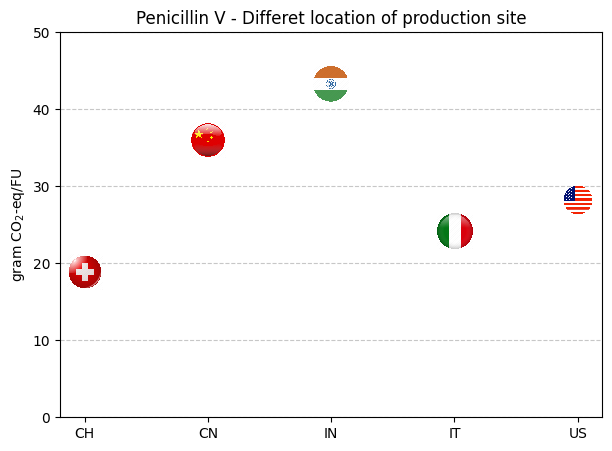

In [60]:
# Create some data
data_V = {'': list(penV.keys()), y_label: list(penV.values())}
df_V = pd.DataFrame(data_V)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=df_V, x='', y=y_label, ax=ax, s=10)

# Add custom markers
for (xi, yi) in zip(df_V[''], df_V[y_label]):
    for c, i in img_dct.items():
        if c in xi:
            imagebox = OffsetImage(i, zoom=0.025)
    ab = AnnotationBbox(imagebox, (xi, yi), frameon=False)
    ax.add_artist(ab)

# Add grid lines for the y-axis
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove x-ticks
ax.set_xticks(range(len(x_tick_label)))
ax.set_xticklabels(x_tick_label)
ax.set_ylim(0, 50)
plt.title("Penicillin V - Differet location of production site")
plt.show()